import warnings 
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import sys
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
column_data_types = {'IsBeta' : 'Int8',
                 'RtpStateBitfield' : 'Int16',
                 'IsSxsPassiveMode' : 'Int8',
                 'HasTpm' : 'Int8',
                 'CountryIdentifier' : 'Int64',
                 'CityIdentifier' : 'Int64',
                 'OrganizationIdentifier' : 'Int64',
                 'IsProtected' : 'Int8',
                 'AutoSampleOptIn' : 'Int8',
                 'SMode' : 'Int8',
                 'Firewall' : 'Int8',
                 'Census_HasOpticalDiskDrive' : 'Int8',
                 'Census_IsPortableOperatingSystem' : 'Int8',
                 'Census_IsFlightsDisabled' : 'Int8',
                 'Census_IsSecureBootEnabled' : 'Int8',
                 'Census_IsWIMBootEnabled' : 'Int8',
                 'Census_IsVirtualDevice' : 'Int8',
                 'Census_IsTouchEnabled' : 'Int8',
                 'Census_IsPenCapable' : 'Int8',
                 'Census_IsAlwaysOnAlwaysConnectedCapable': 'Int8',
                 'Wdft_IsGamer' : 'Int8',
                 'HasDetections' : 'int'}

In [4]:
columns_to_ignore = ('DefaultBrowsersIdentifier',  # 95.14% NA values
                     'PuaMode', # 99.97% NA values
                     'Census_ProcessorClass', # 99.59% NA values.
                     'Census_InternalBatteryType', # 71.05% NA values
                     'Census_IsFlightingInternal', #83.04% NA values
                     'Census_ThresholdOptIn', # 63.52% NA values
                     
                     # numerical features
                     'Census_PrimaryDiskTotalCapacity', 
                     'Census_SystemVolumeTotalCapacity', 
                     'Census_TotalPhysicalRAM',        
                     'Census_InternalPrimaryDisplayResolutionHorizontal',
                     'Census_InternalPrimaryDisplayResolutionVertical',
                     'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                     'Census_InternalBatteryNumberOfCharges',
                     
                     'IsBeta', 
                     'AutoSampleOptIn', 
                     'UacLuaenable', 
                     'Census_IsWIMBootEnabled',
                     
                     'Census_FlightRing_not',
                     'Census_IsAlwaysOnAlwaysConnectedCapable',
                     'Census_IsSecureBootEnabled',
                     'Census_IsTouchEnabled',
                     'Census_IsVirtualDevice',
                     'SMode'
                    )

In [5]:
label_column = 'HasDetections'

## Loading the training dataset

Dataset is very large, if you try to load it entirely without columns_to_ignore and without defining the column data types, the kernel will most likely crash.

In [6]:
train_df = pd.read_csv('/kaggle/input/microsoft-malware-prediction/train.csv',usecols = lambda x: x not in columns_to_ignore,dtype = column_data_types)
train_df.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,...,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightsDisabled,Census_FlightRing,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsPenCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,7,0,53447.0,1.0,1.0,...,IS_GENUINE,Retail,0,Retail,628.0,36144.0,0,0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,7,0,53447.0,1.0,1.0,...,OFFLINE,Retail,0,NOT_SET,628.0,57858.0,0,0,8.0,0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,7,0,53447.0,1.0,1.0,...,IS_GENUINE,OEM:NONSLP,0,Retail,142.0,52682.0,0,0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,7,0,53447.0,1.0,1.0,...,IS_GENUINE,OEM:NONSLP,0,Retail,355.0,20050.0,0,0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,7,0,53447.0,1.0,1.0,...,IS_GENUINE,Retail,0,Retail,355.0,19844.0,0,0,1.0,1


In [7]:
for col in train_df.columns:
    print(f'"{col}" has {train_df[col].nunique()} unique values and {train_df[col].isna().sum() / len(train_df) * 100:.5f}% NA values.')

"MachineIdentifier" has 8921483 unique values and 0.00000% NA values.
"ProductName" has 6 unique values and 0.00000% NA values.
"EngineVersion" has 70 unique values and 0.00000% NA values.
"AppVersion" has 110 unique values and 0.00000% NA values.
"AvSigVersion" has 8531 unique values and 0.00000% NA values.
"RtpStateBitfield" has 7 unique values and 0.36225% NA values.
"IsSxsPassiveMode" has 2 unique values and 0.00000% NA values.
"AVProductStatesIdentifier" has 28970 unique values and 0.40600% NA values.
"AVProductsInstalled" has 8 unique values and 0.40600% NA values.
"AVProductsEnabled" has 6 unique values and 0.40600% NA values.
"HasTpm" has 2 unique values and 0.00000% NA values.
"CountryIdentifier" has 222 unique values and 0.00000% NA values.
"CityIdentifier" has 107366 unique values and 3.64748% NA values.
"OrganizationIdentifier" has 49 unique values and 30.84149% NA values.
"GeoNameIdentifier" has 292 unique values and 0.00239% NA values.
"LocaleEnglishNameIdentifier" has 27

<AxesSubplot: xlabel='HasDetections', ylabel='count'>

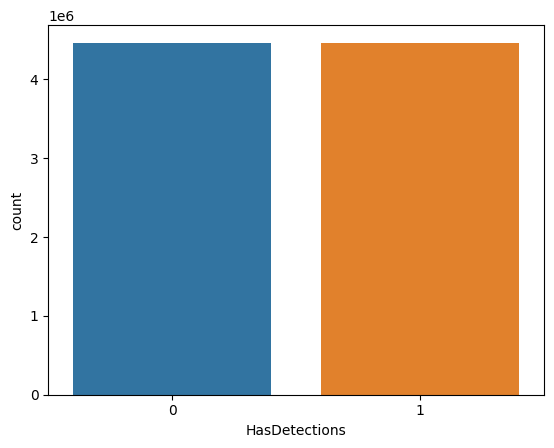

In [8]:
sns.countplot(x = train_df[label_column], orient = "h")

# Data Preprocessing

In [9]:
train_df.drop(columns = ['MachineIdentifier'], inplace = True)

In [10]:
def categorical_preprocessing(df):
    temp = df.copy()
    
    cols = temp.select_dtypes(include = [object]).columns.tolist()   
    temp[cols] = temp[cols].astype(str).apply(lambda x: x.str.lower().apply(sys.intern))
    
    os_build_lab_cat = 'OsBuildLab'
    if os_build_lab_cat in temp.columns:
        os_build_lab_df = temp[os_build_lab_cat].str.split(pat = '.', n = 5, expand = True)
        os_build_lab_df = os_build_lab_df.astype(str).apply(lambda x: x.str.lower().apply(sys.intern))
        os_build_lab_df = os_build_lab_df.add_prefix(os_build_lab_cat + '_')
        
        temp = pd.concat([temp, os_build_lab_df], axis = 1)
        temp = temp.drop(columns = os_build_lab_cat)
    
    smart_screen_cat = 'SmartScreen'
    if smart_screen_cat in temp.columns:
        temp.loc[temp[smart_screen_cat] == 'promt', smart_screen_cat] = 'prompt'
        temp.loc[temp[smart_screen_cat] == '00000000', smart_screen_cat] = '0'
        temp[smart_screen_cat] = temp[smart_screen_cat].astype(str).apply(sys.intern)
        
    disk_type_cat = 'Census_PrimaryDiskTypeName'
    if disk_type_cat in temp.columns:
        disk_types = ['HDD', 'SSD']
        temp.loc[~temp[disk_type_cat].isin(disk_types), disk_type_cat] == 'na'                                
        temp[disk_type_cat] = temp[disk_type_cat].astype(str).apply(sys.intern)
        
    role_name_cat = 'Census_PowerPlatformRoleName'
    if role_name_cat in temp.columns:
        na_types = ['unspecified', 'unknown', np.nan]
        temp.loc[temp[role_name_cat].isin(na_types), role_name_cat] == 'na'                             
        temp[role_name_cat] = temp[role_name_cat].astype(str).apply(sys.intern)
    
    return temp

In [11]:
train_df = categorical_preprocessing(train_df)
train_df.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,...,Census_FirmwareVersionIdentifier,Census_IsPenCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,OsBuildLab_0,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3,OsBuildLab_4
0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,7,0,53447.0,1.0,1.0,1,...,36144.0,0,0,10.0,0,17134,1,amd64fre,rs4_release,180410-1804
1,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,7,0,53447.0,1.0,1.0,1,...,57858.0,0,0,8.0,0,17134,1,amd64fre,rs4_release,180410-1804
2,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,7,0,53447.0,1.0,1.0,1,...,52682.0,0,0,3.0,0,17134,1,amd64fre,rs4_release,180410-1804
3,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,7,0,53447.0,1.0,1.0,1,...,20050.0,0,0,3.0,1,17134,1,amd64fre,rs4_release,180410-1804
4,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,7,0,53447.0,1.0,1.0,1,...,19844.0,0,0,1.0,1,17134,1,amd64fre,rs4_release,180410-1804


In [12]:
print("Duplicates in the training dataframe :",train_df.duplicated().sum())

Duplicates in the training dataframe : 7727


In [13]:
train_df.drop_duplicates(inplace = True)

In [14]:
#Return label column and drop it from the training dataframe.
y = train_df.pop(label_column)

In [15]:
string_columns = train_df.select_dtypes(include = 'object').columns
not_string_columns = train_df.select_dtypes(exclude = 'object').columns

In [16]:
na_value = -1

train_df[string_columns] = train_df[string_columns].fillna('na')
train_df[not_string_columns] = train_df[not_string_columns].fillna(na_value)
train_df.isna().sum()

ProductName         0
EngineVersion       0
AppVersion          0
AvSigVersion        0
RtpStateBitfield    0
                   ..
OsBuildLab_0        0
OsBuildLab_1        0
OsBuildLab_2        0
OsBuildLab_3        0
OsBuildLab_4        0
Length: 63, dtype: int64

In [17]:
X_train, X_val, y_train, y_val = train_test_split(train_df, y, test_size = 0.2, random_state = 42)

In [18]:
del train_df, y

In [19]:
cols = X_train.columns.tolist()

**Ordinal Encoding**

Encode the categorical features in our training data as an integer array.

The input to ordinal transformer should be an array-like of integers or strings, denoting the values taken on by categorical (discrete) features. The features are converted to ordinal integers. This results in a single column of integers (0 to n_categories - 1) per feature.

In [20]:
unknown_value = -100
ord_enc = OrdinalEncoder(handle_unknown = 'use_encoded_value', dtype = 'int32', unknown_value = unknown_value)
X_train_encoded = ord_enc.fit_transform(X_train)
X_val_encoded = ord_enc.transform(X_val)

In [21]:
maximum_values = X_train_encoded.max(axis = 0) + 1
X_val_encoded = np.where(X_val_encoded == unknown_value, maximum_values, X_val_encoded)

In [22]:
del X_train, X_val

# Modelling

In [23]:
X_sample, _, y_sample, _ = train_test_split(X_train_encoded, y_train, train_size = 0.1, random_state = 42)

In [24]:
parameters = {
              'n_estimators' : [500, 600], 'max_depth' : [7, 8],
              'colsample_bytree' : [0.6, 0.7], 'num_leaves' : [70, 80]
             }

clf = lgb.LGBMClassifier(learning_rate = 0.1)
grid_search_clf = GridSearchCV(clf, parameters, verbose = 2)
grid_search_clf.fit(X_sample, y_sample)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END colsample_bytree=0.6, max_depth=7, n_estimators=500, num_leaves=70; total time=  41.6s
[CV] END colsample_bytree=0.6, max_depth=7, n_estimators=500, num_leaves=70; total time=  42.0s
[CV] END colsample_bytree=0.6, max_depth=7, n_estimators=500, num_leaves=70; total time=  42.6s
[CV] END colsample_bytree=0.6, max_depth=7, n_estimators=500, num_leaves=70; total time=  42.6s
[CV] END colsample_bytree=0.6, max_depth=7, n_estimators=500, num_leaves=70; total time=  41.1s
[CV] END colsample_bytree=0.6, max_depth=7, n_estimators=500, num_leaves=80; total time=  43.5s
[CV] END colsample_bytree=0.6, max_depth=7, n_estimators=500, num_leaves=80; total time=  43.5s
[CV] END colsample_bytree=0.6, max_depth=7, n_estimators=500, num_leaves=80; total time=  42.8s
[CV] END colsample_bytree=0.6, max_depth=7, n_estimators=500, num_leaves=80; total time=  43.9s
[CV] END colsample_bytree=0.6, max_depth=7, n_estimators=500, num_leaves=80

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'colsample_bytree': [0.6, 0.7], 'max_depth': [7, 8],
                         'n_estimators': [500, 600], 'num_leaves': [70, 80]},
             verbose=2)

In [25]:
print("These are the best parameters from grid search -")
grid_search_clf.best_params_

These are the best parameters from grid search -


{'colsample_bytree': 0.6,
 'max_depth': 7,
 'n_estimators': 600,
 'num_leaves': 80}

**Grid Searching the best parameters for our Light Gradient Boosting Model, this would enable us to get the best score on the test set**

In [26]:
clf_lgbm = grid_search_clf.best_estimator_

In [27]:
clf_lgbm.fit(X_train_encoded, y_train,
           eval_set = [(X_train_encoded, y_train), (X_val_encoded, y_val)],
           eval_names = ['train', 'val'],
           eval_metric ='auc',
           callbacks = [lgb.log_evaluation(50), lgb.early_stopping(5)])

Training until validation scores don't improve for 5 rounds
[50]	train's auc: 0.707538	train's binary_logloss: 0.620041	val's auc: 0.707239	val's binary_logloss: 0.620295
[100]	train's auc: 0.716732	train's binary_logloss: 0.613391	val's auc: 0.71605	val's binary_logloss: 0.613876
[150]	train's auc: 0.721677	train's binary_logloss: 0.609754	val's auc: 0.720625	val's binary_logloss: 0.610501
[200]	train's auc: 0.7248	train's binary_logloss: 0.607351	val's auc: 0.72336	val's binary_logloss: 0.608375
[250]	train's auc: 0.727236	train's binary_logloss: 0.605482	val's auc: 0.725456	val's binary_logloss: 0.60676
[300]	train's auc: 0.72958	train's binary_logloss: 0.603606	val's auc: 0.727449	val's binary_logloss: 0.605148
[350]	train's auc: 0.731211	train's binary_logloss: 0.602302	val's auc: 0.728711	val's binary_logloss: 0.604111
[400]	train's auc: 0.732845	train's binary_logloss: 0.601027	val's auc: 0.730004	val's binary_logloss: 0.6031
[450]	train's auc: 0.734041	train's binary_logloss: 0

LGBMClassifier(colsample_bytree=0.6, max_depth=7, n_estimators=600,
               num_leaves=80)

In [28]:
del y_train, y_val, X_train_encoded, X_val_encoded

# Testing Phase


In [29]:
test_df = pd.read_csv('/kaggle/input/microsoft-malware-prediction/test.csv',
                      usecols = lambda x: x not in columns_to_ignore,
                      dtype = column_data_types)
test_df.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,...,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightsDisabled,Census_FlightRing,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsPenCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,0000010489e3af074adeac69c53e555e,win8defender,1.1.15400.5,4.18.1810.5,1.281.501.0,7,0,53447.0,1.0,1.0,...,0,IS_GENUINE,OEM:DM,0,Retail,807.0,8554.0,0,0,7.0
1,00000176ac758d54827acd545b6315a5,win8defender,1.1.15400.4,4.18.1809.2,1.279.301.0,7,0,53447.0,1.0,1.0,...,0,IS_GENUINE,Retail,0,Retail,554.0,33105.0,0,1,12.0
2,0000019dcefc128c2d4387c1273dae1d,win8defender,1.1.15300.6,4.18.1809.2,1.277.230.0,7,0,49480.0,2.0,1.0,...,0,IS_GENUINE,OEM:DM,0,Retail,556.0,63396.0,0,1,11.0
3,0000055553dc51b1295785415f1a224d,win8defender,1.1.15400.5,4.18.1810.5,1.281.664.0,7,0,42160.0,2.0,1.0,...,0,IS_GENUINE,OEM:DM,0,Retail,628.0,26320.0,0,0,10.0
4,00000574cefffeca83ec8adf9285b2bf,win8defender,1.1.15400.4,4.18.1809.2,1.279.236.0,7,0,53447.0,1.0,1.0,...,0,IS_GENUINE,Retail,0,Retail,556.0,63269.0,0,1,3.0


In [30]:
submission = test_df.pop('MachineIdentifier').to_frame()

**We apply the same pre-processing function that we defined earlier for the training datafrane**

In [31]:
test_df = categorical_preprocessing(test_df)

In [32]:
test_df[string_columns] = test_df[string_columns].fillna('na')
test_df[not_string_columns] = test_df[not_string_columns].fillna(na_value)
test_df.isna().sum()

ProductName         0
EngineVersion       0
AppVersion          0
AvSigVersion        0
RtpStateBitfield    0
                   ..
OsBuildLab_0        0
OsBuildLab_1        0
OsBuildLab_2        0
OsBuildLab_3        0
OsBuildLab_4        0
Length: 63, dtype: int64

**We carry out ordinal transformation as we had performed earlier on the training dataframe**

In [33]:
test_df = ord_enc.transform(test_df)
test_df = np.where(test_df == unknown_value, maximum_values, test_df)

**We create the predictions and load it into a csv for submission to the competition**

In [34]:
submission[label_column] = clf_lgbm.predict_proba(test_df)[:, 1]
submission.head()

,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.489514
1,00000176ac758d54827acd545b6315a5,0.561992
2,0000019dcefc128c2d4387c1273dae1d,0.460239
3,0000055553dc51b1295785415f1a224d,0.376319
4,00000574cefffeca83ec8adf9285b2bf,0.484574
